##LeNet-5 CNN architecture in Pytorch using Fashion-MNIST data set

## 1. Loading the data set.

In [1]:
import torch

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
from torchvision import datasets
from torchvision import transforms 

to_transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor()
    ])

# Loading the Dataset Fashion-MNIST
MNIST_train_data = datasets.FashionMNIST(
    root='data', train=True, 
    transform=to_transform, download=True,)
MNIST_test_data = datasets.FashionMNIST(
    root='data', train=False, 
    transform=to_transform)

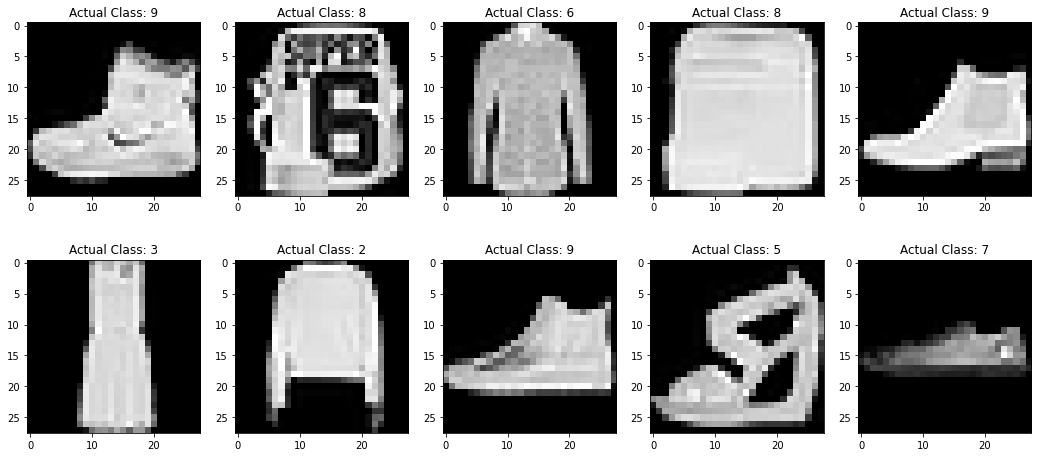

In [3]:
import math
import cv2
from matplotlib import pyplot as plt

display_num_of_images = 10
display_per_row = 5
rows, cols = math.ceil(display_num_of_images/display_per_row), display_per_row
row, col = 0, 0
f, ax_arr = plt.subplots(rows, cols, figsize=(18, 8))
train_data_len = len(MNIST_train_data.data)
for i in range(train_data_len):
    if i % (train_data_len/display_num_of_images) == 0:
        sub_ax = ax_arr[row, col]
        sub_ax.imshow(MNIST_train_data.data[i], cmap='gray')
        sub_ax.set_title(f'Actual Class: {MNIST_train_data.targets[i]}')
        col += 1
        if (col == display_per_row):
          col, row = 0, (row + 1)
        
plt.show()

In [4]:
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Data Loader fpr 
batch_size = 32
loaders = {
    'train': torch.utils.data.DataLoader(
        MNIST_train_data, batch_size=batch_size, 
        shuffle=True, num_workers=2),

    'test': torch.utils.data.DataLoader(
        MNIST_test_data, batch_size=batch_size, 
        shuffle=True, num_workers=2),
}

## 3. Implementing LeNet CNN Architecture using PyTorch.

In [5]:
from torch import nn

# PyTorch Model for LeNet
class LeNet_CNN_Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=num_classes),
            nn.Softmax(dim=1),
        )
        

    def forward(self, X):
        X = self.conv_layers(X)
        X = X.view(X.size(0), -1)
        X = self.linear_layers(X)
        return X

In [6]:
LeNet_model = LeNet_CNN_Net(10).to(device)
print(LeNet_model)

LeNet_CNN_Net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)


In [7]:
from torch.optim import Adam
import statistics

# Trains the Model Classifier
def train_model_classifier(train_loader,  
                           NNModelClassifier, 
                           epochs=25):
    loss_function = nn.CrossEntropyLoss()
    optimization_algorithm = Adam(NNModelClassifier.parameters(), lr=0.01)
    training_loss = []
    training_accuracy = []
    for epoch in range(epochs):
        batch_train_loss = []
        for train_X, train_y in train_loader:
            optimization_algorithm.zero_grad()
            output = NNModelClassifier(train_X.to(device))
            loss = loss_function(output, train_y.to(device))
            loss.backward()
            optimization_algorithm.step()
            batch_train_loss.append(loss.item())
        epoch_train_loss = statistics.mean(batch_train_loss)
        training_loss.append(epoch_train_loss)  
        
        correct_count = 0
        with torch.no_grad():
            for train_X, train_y in train_loader:
                output = NNModelClassifier(train_X.to(device))
                output = torch.max(output,1)[1]
                correct_count += (output == train_y.to(device)).float().sum()
            accuracy = correct_count.item()/len(MNIST_train_data.data)*100
            training_accuracy.append(accuracy)
        print(f'Epoch {epoch:2d} - ' + \
              f'Training => Loss:{loss:0.12f}, Accuracy:{accuracy:0.12f}')
    return NNModelClassifier, training_loss, training_accuracy

In [8]:
# Training the model
ret = train_model_classifier(
    loaders['train'],
    LeNet_model, 
    # epochs=2,
    )

trained_classifier_model, training_loss, training_accuracy = ret

Epoch  0 - Training => Loss:1.813230991364, Accuracy:70.001666666667
Epoch  1 - Training => Loss:1.773869037628, Accuracy:71.206666666667
Epoch  2 - Training => Loss:1.661085486412, Accuracy:72.666666666667
Epoch  3 - Training => Loss:1.731414437294, Accuracy:71.761666666667
Epoch  4 - Training => Loss:1.685608625412, Accuracy:69.983333333333
Epoch  5 - Training => Loss:1.753548264503, Accuracy:69.150000000000
Epoch  6 - Training => Loss:1.861622571945, Accuracy:71.805000000000
Epoch  7 - Training => Loss:1.754107236862, Accuracy:66.411666666667
Epoch  8 - Training => Loss:1.732850670815, Accuracy:70.843333333333
Epoch  9 - Training => Loss:1.822624206543, Accuracy:69.418333333333
Epoch 10 - Training => Loss:1.755439043045, Accuracy:64.848333333333
Epoch 11 - Training => Loss:1.618232607841, Accuracy:67.821666666667
Epoch 12 - Training => Loss:1.865085959435, Accuracy:66.443333333333
Epoch 13 - Training => Loss:1.749853610992, Accuracy:70.560000000000
Epoch 14 - Training => Loss:1.7757

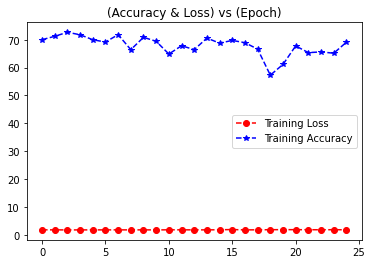

In [9]:
# # Sub plots for the Training Loss and Accuracy
# f, ax_arr = plt.subplots(1, 2, figsize=(12, 6))
# ax_arr[0].plot(training_loss, label='Training Loss', 
#                marker='o', linestyle='--', color='r')
# ax_arr[0].set_title('Loss vs Epoch')
# ax_arr[0].legend()
# ax_arr[1].plot(training_accuracy, label='Training Accuracy', 
#                marker='*', linestyle='--', color='b')
# ax_arr[1].set_title('Accuracy vs Epoch')
# ax_arr[1].legend()
# plt.show()

# Plotting the Training Accuracy and Loss
plt.plot(training_loss, label='Training Loss', 
         marker='o', linestyle='--', color='r')
plt.plot(training_accuracy, label='Training Accuracy', 
         marker='*', linestyle='--', color='b')
plt.title('(Accuracy & Loss) vs (Epoch)')
plt.legend()
plt.show()

## 4. Generating predictions for the test set.

4 8

batchId: 0


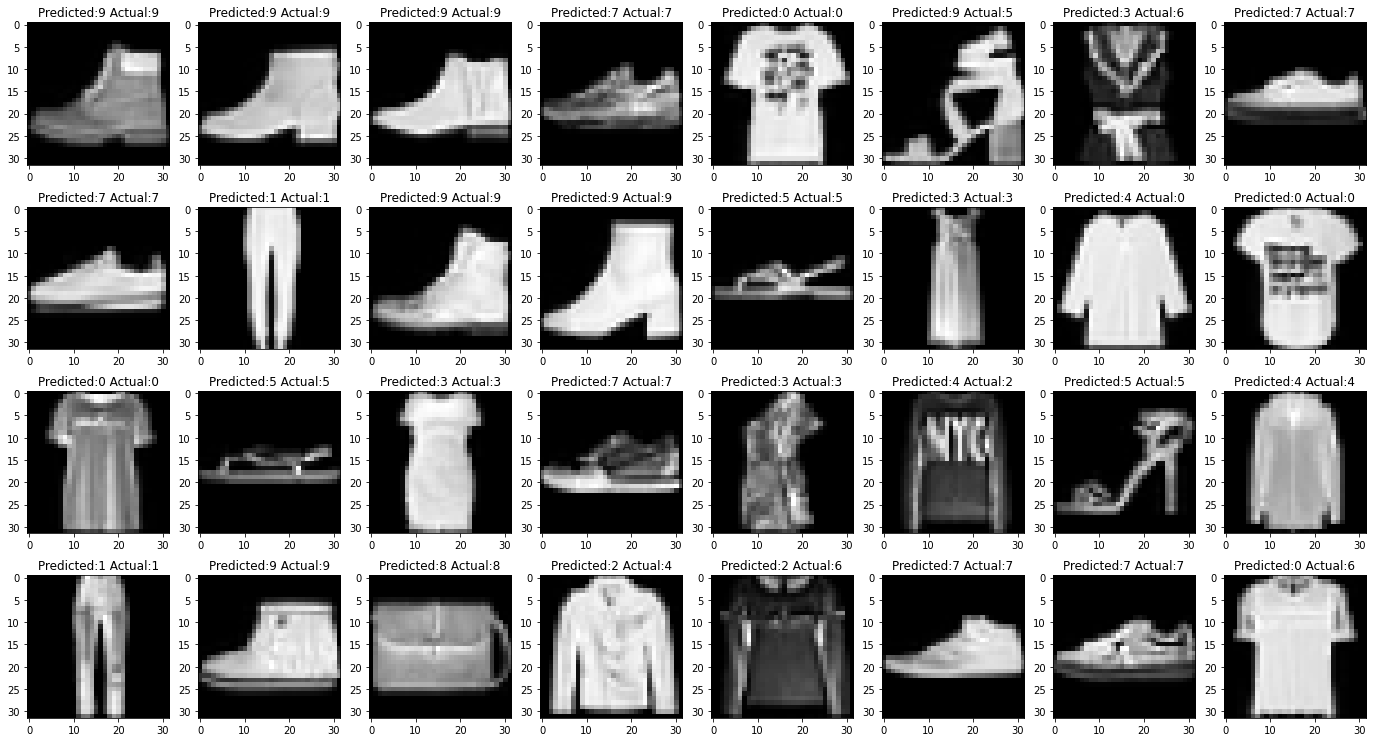


batchId: 100


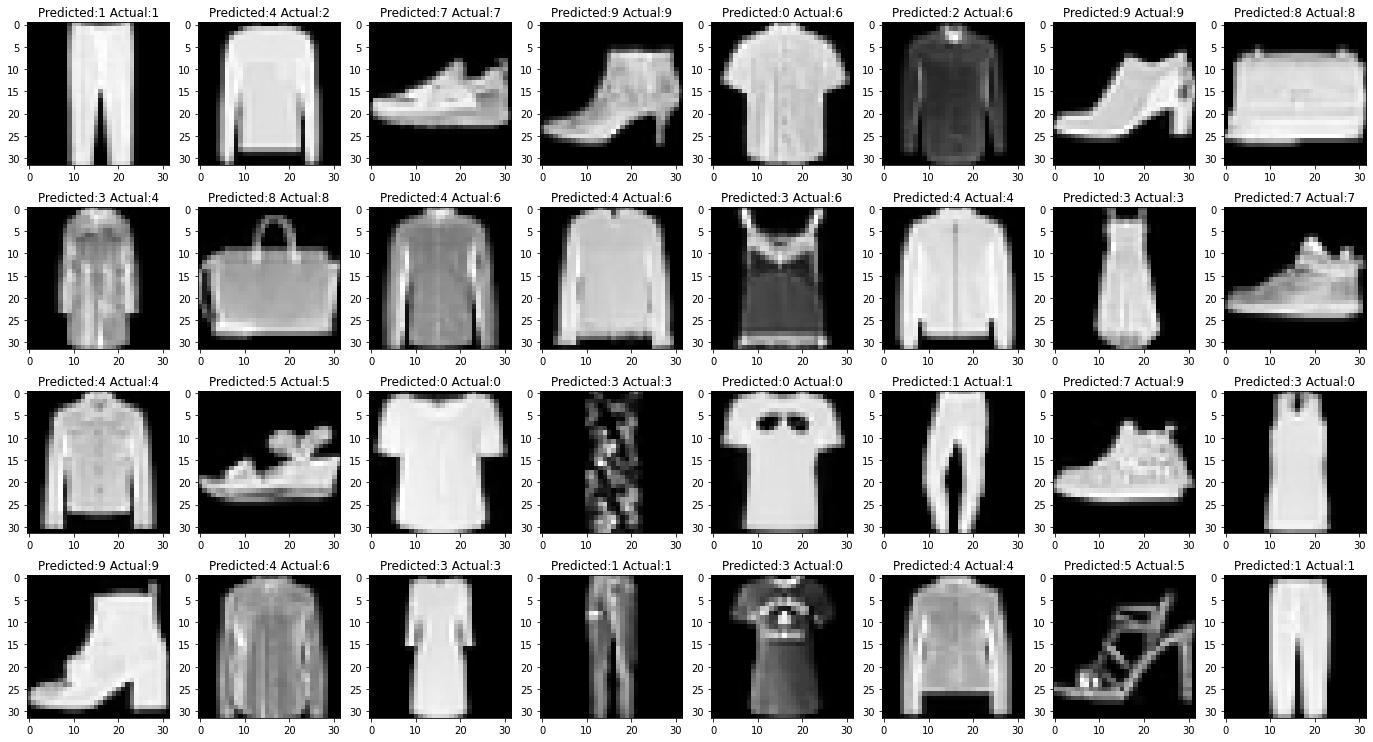


batchId: 200


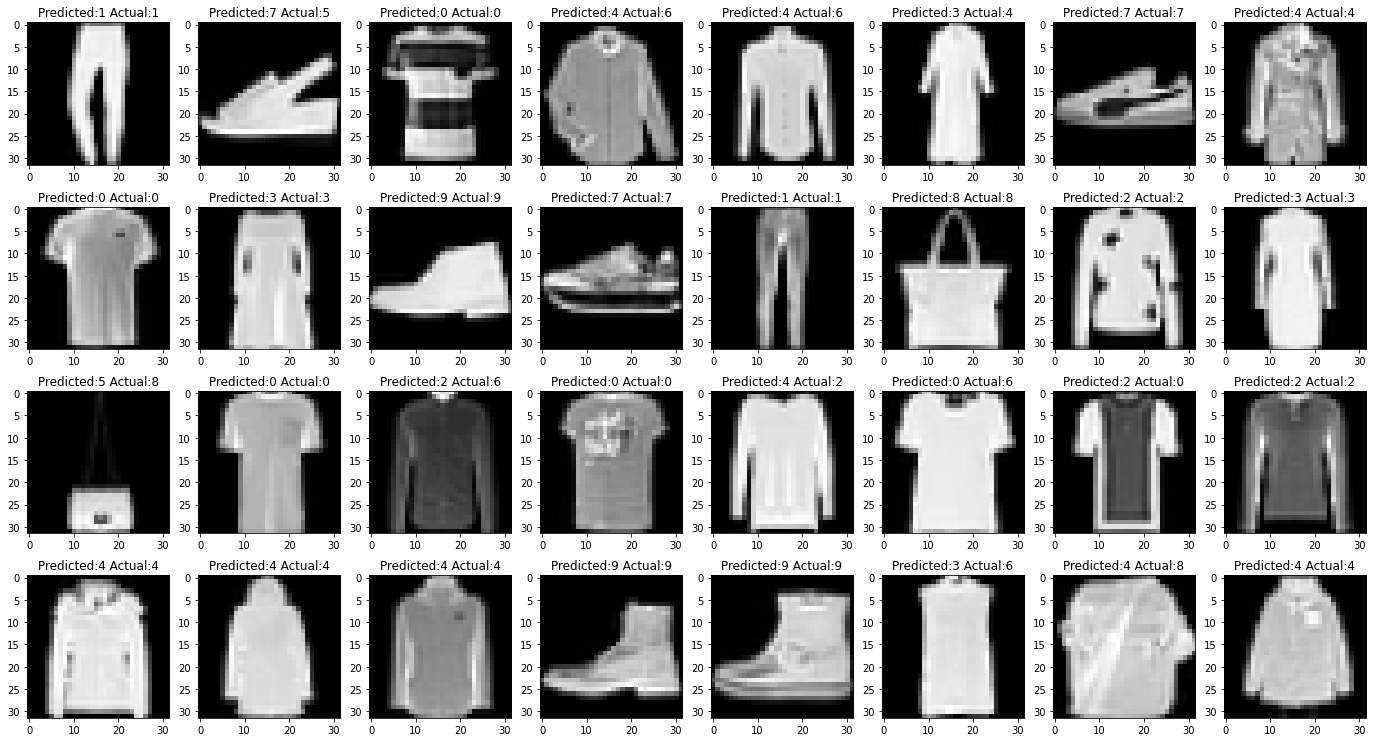


batchId: 300


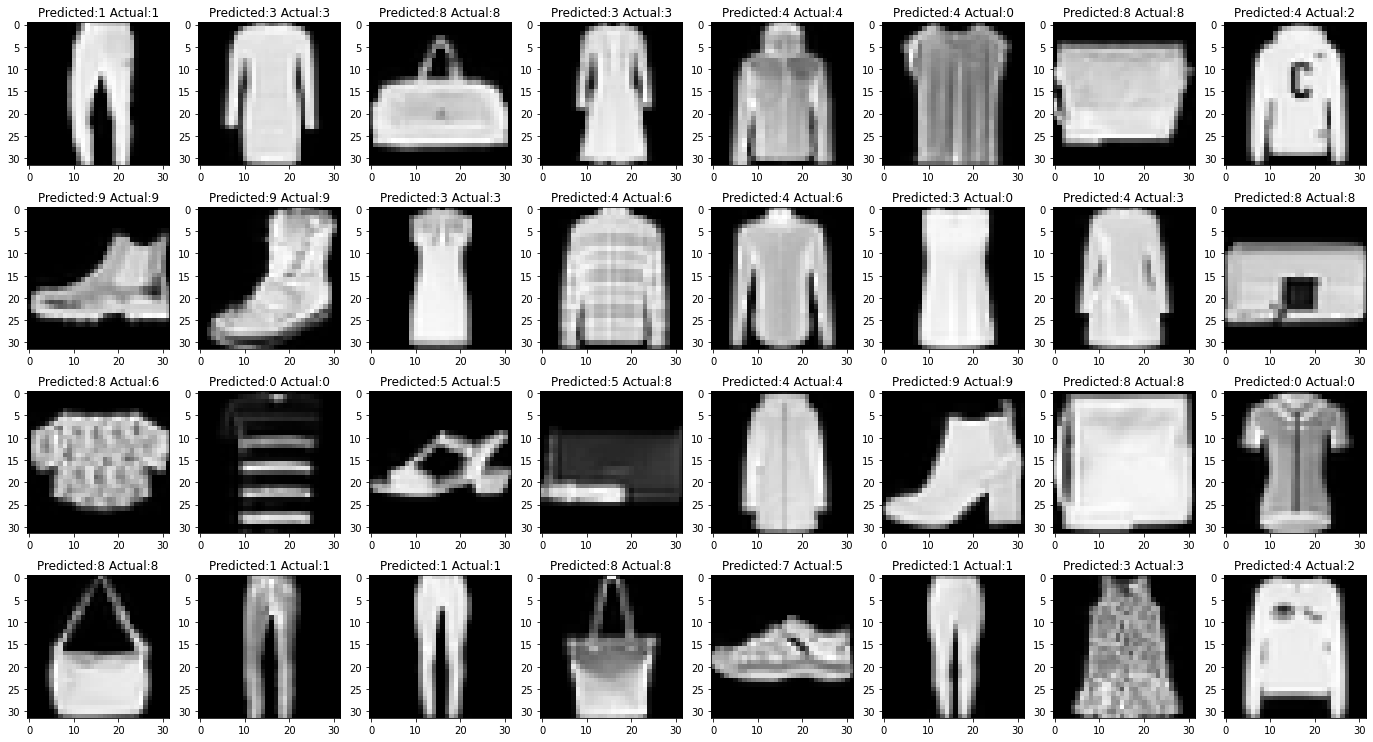

In [10]:
import math

# Plot Generated Predictions on Test Images
display_num_of_images = batch_size  # batch_size=32
display_per_row = 8
rows, cols = math.ceil(display_num_of_images/display_per_row), display_per_row
print(rows, cols)

with torch.no_grad():
    batch = 0
    for batch_X, batch_y in loaders['test']:
        output = trained_classifier_model(batch_X.to(device))
        output = torch.max(output,1)[1]
        if (batch % 100 == 0):
          row, col = 0, 0
          f, ax_arr = plt.subplots(rows, cols, figsize=(24, 13))
          print(f"\nbatchId: {batch}")
          for idx in range(len(batch_X)):
              sub_ax = ax_arr[row, col]
              sub_ax.imshow(batch_X[idx][0], cmap='gray')
              sub_ax.set_title(f'Predicted:{output[idx]} Actual:{batch_y[idx]}')
              col += 1
              if (col == display_per_row):
                col, row = 0, (row + 1)
          plt.show()
        batch += 1